In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')




Saving cleaned_credit.csv to cleaned_credit.csv
User uploaded file "cleaned_credit.csv" with length 7221280 bytes


In [37]:
df = pd.read_csv("cleaned_credit.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (149986, 11)


,default,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [38]:
default_rate = df["default"].mean()
print(f"Overall Default Rate: {default_rate:.2%}")


Overall Default Rate: 6.68%


In [39]:
df["income_bucket"] = pd.qcut(
    df["MonthlyIncome"],
    q=5,
    duplicates="drop"
)


/tmp/ipython-input-2256879319.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default = df.groupby("income_bucket")["default"].mean()


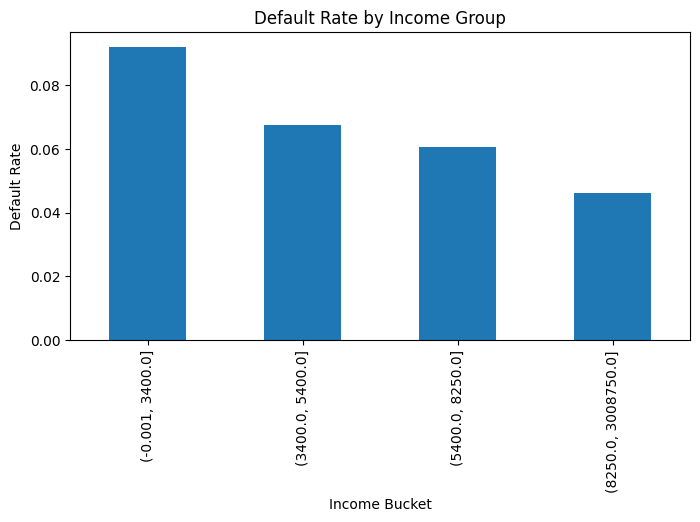

In [40]:
income_default = df.groupby("income_bucket")["default"].mean()

income_default.plot(kind="bar", figsize=(8,4))
plt.title("Default Rate by Income Group")
plt.ylabel("Default Rate")
plt.xlabel("Income Bucket")
plt.show()


In [42]:
df["income_bucket"] = pd.qcut(
    df["MonthlyIncome"],
    q=5,
    duplicates="drop"
)



/tmp/ipython-input-2256879319.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default = df.groupby("income_bucket")["default"].mean()


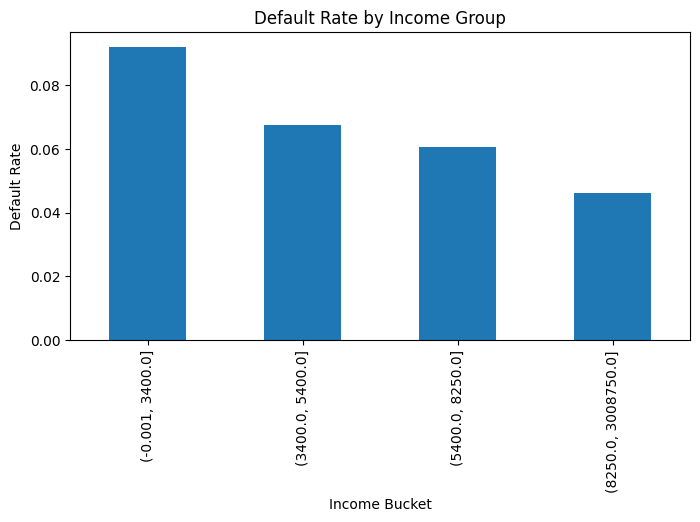

In [43]:
income_default = df.groupby("income_bucket")["default"].mean()

income_default.plot(kind="bar", figsize=(8,4))
plt.title("Default Rate by Income Group")
plt.ylabel("Default Rate")
plt.xlabel("Income Bucket")
plt.show()


/tmp/ipython-input-1021501581.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  debt_default = df.groupby("debt_bucket")["default"].mean()


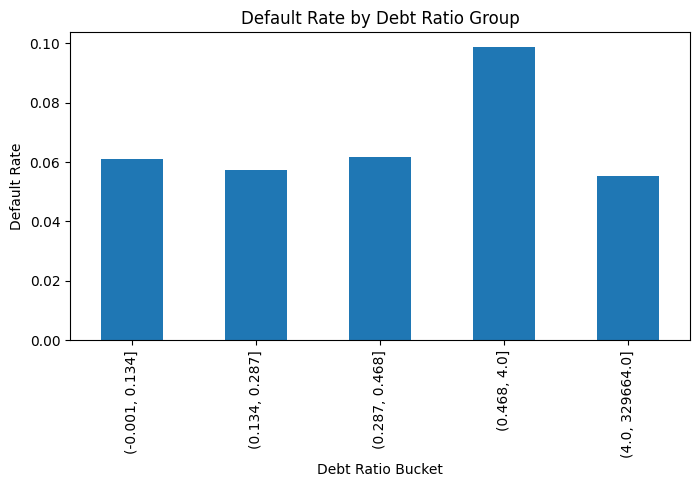

In [44]:
df["debt_bucket"] = pd.qcut(
    df["DebtRatio"],
    q=5,
    duplicates="drop"
)

debt_default = df.groupby("debt_bucket")["default"].mean()

debt_default.plot(kind="bar", figsize=(8,4))
plt.title("Default Rate by Debt Ratio Group")
plt.ylabel("Default Rate")
plt.xlabel("Debt Ratio Bucket")
plt.show()


/tmp/ipython-input-659090532.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_default = df.groupby("age_bucket")["default"].mean()


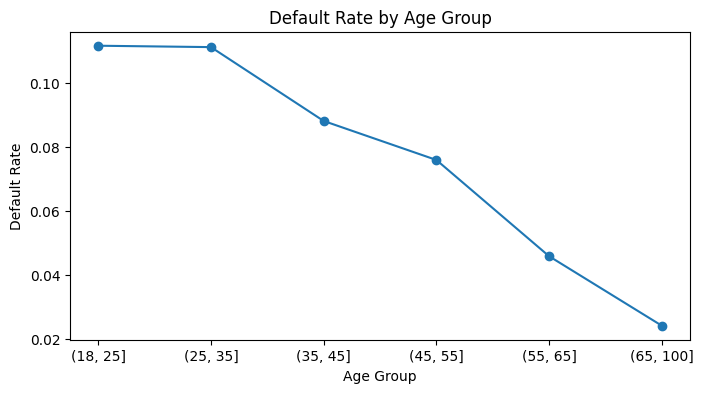

In [46]:
df["age_bucket"] = pd.cut(
    df["age"],
    bins=[18,25,35,45,55,65,100]
)

age_default = df.groupby("age_bucket")["default"].mean()

age_default.plot(kind="line", marker="o", figsize=(8,4))
plt.title("Default Rate by Age Group")
plt.ylabel("Default Rate")
plt.xlabel("Age Group")
plt.show()


## Summary of Exploratory Findings

- Default risk is higher among low-income and high-debt borrowers
- Past delinquency history is the strongest predictor of default
- Credit risk varies non-linearly across age groups
- These findings are consistent with real-world lending intuition and guide model design


# Credit Risk Modeling

## Objective
The objective of this notebook is to build an interpretable credit risk model to estimate the probability of borrower default.

The focus is on:
- Predicting default probability
- Using explainable models suitable for banking and fintech applications
- Evaluating model performance using risk-appropriate metrics

Logistic regression is used as the baseline model due to its interpretability and widespread use in credit risk analytics.


In [47]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_credit.csv")

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (149986, 11)


,default,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [48]:
df["any_past_due"] = (
    (df["NumberOfTime30-59DaysPastDueNotWorse"] > 0) |
    (df["NumberOfTime60-89DaysPastDueNotWorse"] > 0) |
    (df["NumberOfTimes90DaysLate"] > 0)
).astype(int)

In [90]:
df[[
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "any_past_due"
]].head()

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,any_past_due
0,2,0,0,1
1,0,0,0,0
2,1,0,1,1
3,0,0,0,0
4,1,0,0,1


In [55]:
FEATURES = [
    "MonthlyIncome",
    "DebtRatio",
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "any_past_due"
]

X = df[FEATURES]
y = df["default"]


In [56]:
X.head()


,MonthlyIncome,DebtRatio,RevolvingUtilizationOfUnsecuredLines,age,any_past_due
0,9120.0,0.802982,0.766127,45,1
1,2600.0,0.121876,0.957151,40,0
2,3042.0,0.085113,0.658180,38,1
3,3300.0,0.036050,0.233810,30,0
4,63588.0,0.024926,0.907239,49,1


In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [58]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [59]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"  # handles class imbalance
)

model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [60]:
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]


In [61]:
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC–AUC Score:", round(auc, 4))


ROC–AUC Score: 0.8112


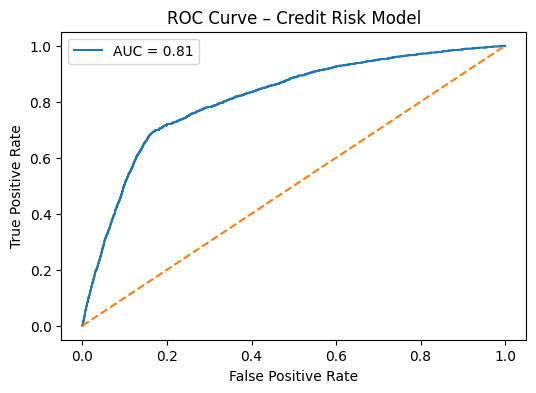

In [62]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Credit Risk Model")
plt.legend()
plt.show()


In [63]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coefficients


,Feature,Coefficient
4,any_past_due,0.899244
2,RevolvingUtilizationOfUnsecuredLines,-0.008416
1,DebtRatio,-0.066996
0,MonthlyIncome,-0.121714
3,age,-0.436140


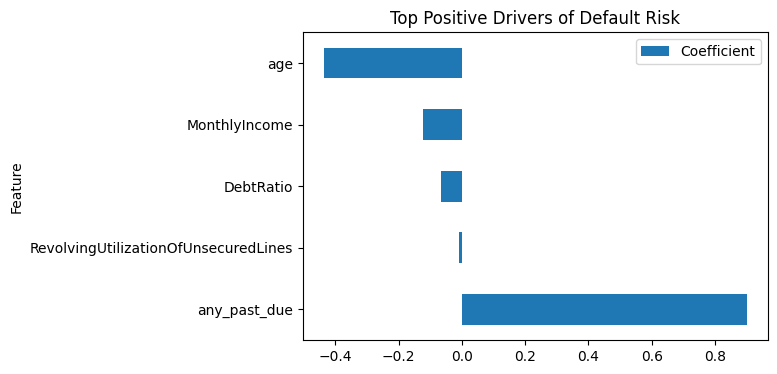

In [64]:
coefficients.head(10).plot(
    x="Feature",
    y="Coefficient",
    kind="barh",
    figsize=(6,4),
    title="Top Positive Drivers of Default Risk"
)
plt.show()


## Model Interpretation and Business Insights

- Past delinquency variables have the strongest positive relationship with default risk
- Higher debt ratios and credit utilization increase default probability
- Income and stable demographic factors reduce credit risk

The model prioritizes interpretability and aligns closely with how banks and fintech lenders evaluate credit risk in practice.


# Credit Decision Framework

## Objective
The objective of this notebook is to convert predicted default probabilities into
practical lending decisions.

This step bridges the gap between predictive modeling and real-world fintech lending
by introducing:
- Risk-based approval thresholds
- Explainable credit decisions
- Risk-adjusted loan pricing

These components reflect how credit risk models are operationalized in practice.


In [89]:
# 1. Feature engineering
df["any_past_due"] = (
    (df["NumberOfTime30-59DaysPastDueNotWorse"] > 0) |
    (df["NumberOfTime60-89DaysPastDueNotWorse"] > 0) |
    (df["NumberOfTimes90DaysLate"] > 0)
).astype(int)

# 2. Keep ONLY 5 features
FEATURES = [
    "MonthlyIncome",
    "DebtRatio",
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "any_past_due"
]

X = df[FEATURES]
y = df["default"]

# 3. Train scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaler expects:", scaler.n_features_in_)


Scaler expects: 5


In [69]:
def credit_decision(prob):
    if prob < 0.10:
        return "Approve"
    elif prob < 0.25:
        return "Review"
    else:
        return "Reject"

results["decision"] = results["default_prob"].apply(credit_decision)

results["decision"].value_counts(normalize=True)


,proportion
decision,
Reject,0.753550
Review,0.244383
Approve,0.002067


In [85]:
model.coef_.shape


(1, 5)

In [83]:
FEATURES = [
    "MonthlyIncome",
    "DebtRatio",
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "any_past_due"
]

X = df[FEATURES]
y = df["default"]


In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

model.fit(X_scaled, y)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [87]:
coefficients = pd.Series(
    model.coef_[0],
    index=X.columns
).sort_values(ascending=False)

coefficients.head(10)


,0
any_past_due,0.908640
RevolvingUtilizationOfUnsecuredLines,-0.016424
DebtRatio,-0.036706
MonthlyIncome,-0.182322
age,-0.439875


In [92]:
def explain_borrower(row, coef, top_n=3):
    contributions = row * coef
    return contributions.sort_values(ascending=False).head(top_n)


In [93]:
sample_borrower = X.iloc[0]


In [94]:
explain_borrower(sample_borrower, coefficients)


,0
any_past_due,0.908640
RevolvingUtilizationOfUnsecuredLines,-0.012582
DebtRatio,-0.029474


In [96]:
def risk_based_interest(prob):
    if prob < 0.10:
        return 0.12   # 12%
    elif prob < 0.25:
        return 0.18   # 18%
    else:
        return 0.25   # 25%

results["interest_rate"] = results["default_prob"].apply(risk_based_interest)

results[["default_prob", "decision", "interest_rate"]].head()


,default_prob,decision,interest_rate
92222,0.255890,Reject,0.25
146786,0.490928,Reject,0.25
76044,0.316890,Reject,0.25
117631,0.299045,Reject,0.25
21982,0.684301,Reject,0.25


In [97]:
def credit_decision(prob):
    if prob < 0.10:
        return "APPROVE"
    elif prob < 0.25:
        return "REVIEW"
    else:
        return "REJECT"

decisions = pd.Series(y_pred_prob).apply(credit_decision)
decisions.value_counts(normalize=True)


,proportion
REJECT,0.650343
REVIEW,0.347923
APPROVE,0.001733


## Key Takeaways

- Credit risk models must translate probabilities into business decisions
- Risk thresholds help balance growth and default risk
- Explainability is critical for regulatory compliance
- Risk-based pricing aligns return with borrower risk

This framework closely mirrors how fintech lenders operationalize credit risk models.

In [98]:
import joblib

joblib.dump(model, "credit_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [99]:
loaded_scaler = joblib.load("scaler.pkl")
print("Loaded scaler expects:", loaded_scaler.n_features_in_)


Loaded scaler expects: 5
